# JPMC Stock Risk Analysis (2020-2025)
**Author:** Socrates Gomes
**Objective:** Identify volatility outliers and analyze the correlation between price shocks and trading volume for risk management.

## 1. Data Acquisition

Downloading the latest JPMC stock data from Kaggle using kagglehub.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rockyt07/jpmc-stock-detailed-data")

print("Path to dataset files:", path)

Path to dataset files: /Users/socratesrgomes/.cache/kagglehub/datasets/rockyt07/jpmc-stock-detailed-data/versions/1


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub

%matplotlib inline

In [3]:
# 1. Load the dataset (using your specific path)
path = "/Users/socratesrgomes/Documents/jpmc-stock-risk-analysis/data/JPM_historical_5year.csv"
df = pd.read_csv(path)

## 2. Statistical Descriptive Analysis
In this section, we prepare the data by calculating daily returns and establish the baseline for our risk analysis. 
By calculating the central tendency and dispersion, we can define what constitutes a "normal" day versus an "extreme" market event.

In [4]:
# 1. Create Daily Returns column
# The raw dataset only contains prices. We need to calculate the daily percentage change first.
df['Daily_Return'] = df['Close'].pct_change()

# 2. Calculate Mean and Std Dev for Returns
# These values will be the foundation for our anomaly detection
mean_ret = df['Daily_Return'].mean()
std_ret = df['Daily_Return'].std()

print(f"Average Daily Return (Mean): {mean_ret:.6f}")
print(f"Market Volatility (Std Dev): {std_ret:.6f}")

# 3. Checking Skewness to understand the distribution shape
# Financial returns often show skewness, indicating a departure from the Normal Distribution.
print(f"Return Skewness: {df['Daily_Return'].skew():.2f}")

Average Daily Return (Mean): 0.001010
Market Volatility (Std Dev): 0.015335
Return Skewness: 0.13


## 3. Visual Outlier Inspection
Before applying numerical filters, we use visual tools to identify anomalies in the data distribution. 
A Boxplot is particularly effective here, as it highlights points that fall beyond the interquartile range (IQR). 
These "dots" represent days of unusual volatility that warrant further investigation.

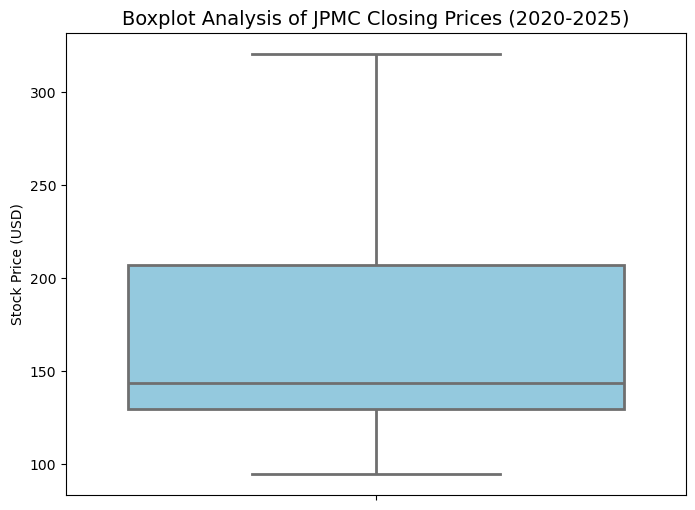

In [5]:
# 3.1 Visual Price Distribution (JPMC Closing Prices)
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['Close'], color='skyblue', linewidth=2)
plt.title('Boxplot Analysis of JPMC Closing Prices (2020-2025)', fontsize=14)
plt.ylabel('Stock Price (USD)')
plt.savefig('/Users/socratesrgomes/Documents/jpmc-stock-risk-analysis/images/jpmc_price_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

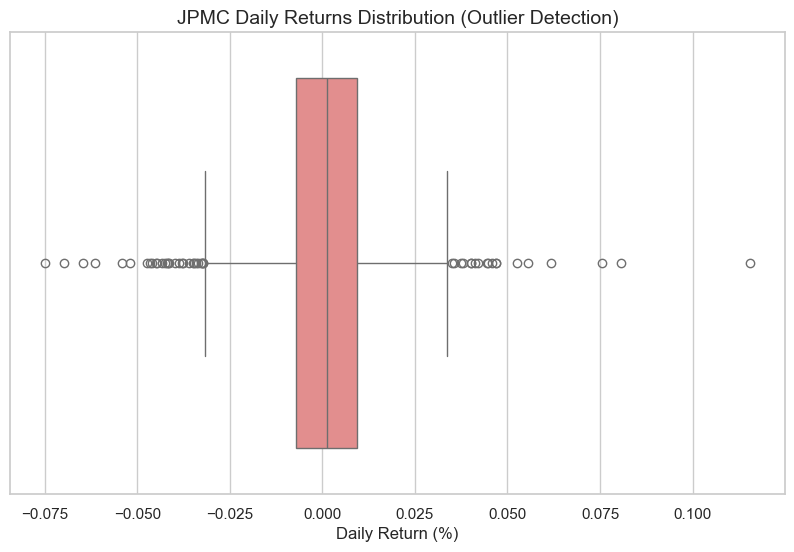

In [6]:
#3.2 Visual Return Distribution:
# Setting the visual style
sns.set_theme(style="whitegrid")

# Creating a Boxplot of Daily Returns
# This will visually confirm the existence of extreme outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Daily_Return'], color='lightcoral')

plt.title('JPMC Daily Returns Distribution (Outlier Detection)', fontsize=14)
plt.xlabel('Daily Return (%)')
plt.savefig('/Users/socratesrgomes/Documents/jpmc-stock-risk-analysis/images/jpmc_return_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Data Refinement (Time-Series Alignment)
To perform a precise time-series analysis, we must ensure the 'Date' column is in the correct format. 
We convert the date strings into Datetime objects and handle timezones to prevent computation errors. 
This step also allows us to verify that the dataset covers the full 5-year period required for this study.

In [7]:
# 1. Convert Date to datetime format
# Fixing the timezone warning by setting utc=True to ensure consistency
df['Date'] = pd.to_datetime(df['Date'], utc=True)

# 2. Verify the historical range
# This confirms our analysis spans from early 2020 to late 2025
print(f"Analysis Start Date: {df['Date'].min()}")
print(f"Analysis End Date: {df['Date'].max()}")

# 3. Quick check on the first few rows to see the new format
df[['Date', 'Close', 'Daily_Return']].head()

Analysis Start Date: 2020-12-14 05:00:00+00:00
Analysis End Date: 2025-12-12 05:00:00+00:00


,Date,Close,Daily_Return
0,2020-12-14 05:00:00+00:00,103.899796,NaN
1,2020-12-15 05:00:00+00:00,105.673897,0.017075
2,2020-12-16 05:00:00+00:00,105.981308,0.002909
3,2020-12-17 05:00:00+00:00,105.103035,-0.008287
4,2020-12-18 05:00:00+00:00,104.584869,-0.004930


## 5. Numerical Outlier Detection (Z-Score)
In this section, we apply the Z-Score to pinpoint the exact dates of extreme market volatility. 
By using a threshold of |Z| > 3, we isolate events that are statistically rare, representing the most significant risk and opportunity periods in JPMC's recent history.

In [8]:
# 1. Calculate Z-Score for each daily return
df['Z_Score'] = (df['Daily_Return'] - mean_ret) / std_ret

# 2. Filter outliers where the absolute Z-Score is greater than 3
# We use .copy() to maintain data integrity for this subset
volatility_outliers = df[df['Z_Score'].abs() > 3].copy()

# 3. Chronological sorting and display
print(f"Total Black Swan events identified: {len(volatility_outliers)}")

# Display the table sorted by Daily Return to see the history of shocks
volatility_outliers[['Date', 'Close', 'Daily_Return', 'Z_Score']].sort_values(by='Daily_Return', ascending=False).head(10)

Total Black Swan events identified: 15


,Date,Close,Daily_Return,Z_Score
980,2024-11-06 05:00:00+00:00,241.938416,0.115445,7.462167
1084,2025-04-09 04:00:00+00:00,232.088089,0.080555,5.187020
586,2023-04-14 04:00:00+00:00,130.815384,0.075510,4.858011
362,2022-05-23 04:00:00+00:00,113.689980,0.061871,3.968680
461,2022-10-13 04:00:00+00:00,101.576996,0.055593,3.559272
467,2022-10-21 04:00:00+00:00,113.520691,0.052527,3.359367
375,2022-06-10 04:00:00+00:00,109.082161,-0.045966,-3.063270
1252,2025-12-09 05:00:00+00:00,300.510010,-0.046636,-3.106928
565,2023-03-15 04:00:00+00:00,120.000923,-0.047244,-3.146603
939,2024-09-10 04:00:00+00:00,200.072647,-0.051889,-3.449487


## 6. Visualizing the Risk Timeline
To better understand the impact of the identified outliers, we plot the JPMC closing price over the 5-year period. 
By highlighting the 15 "Black Swan" events in red, we can visualize exactly when the market experienced extreme volatility and how the stock recovered from these shocks.

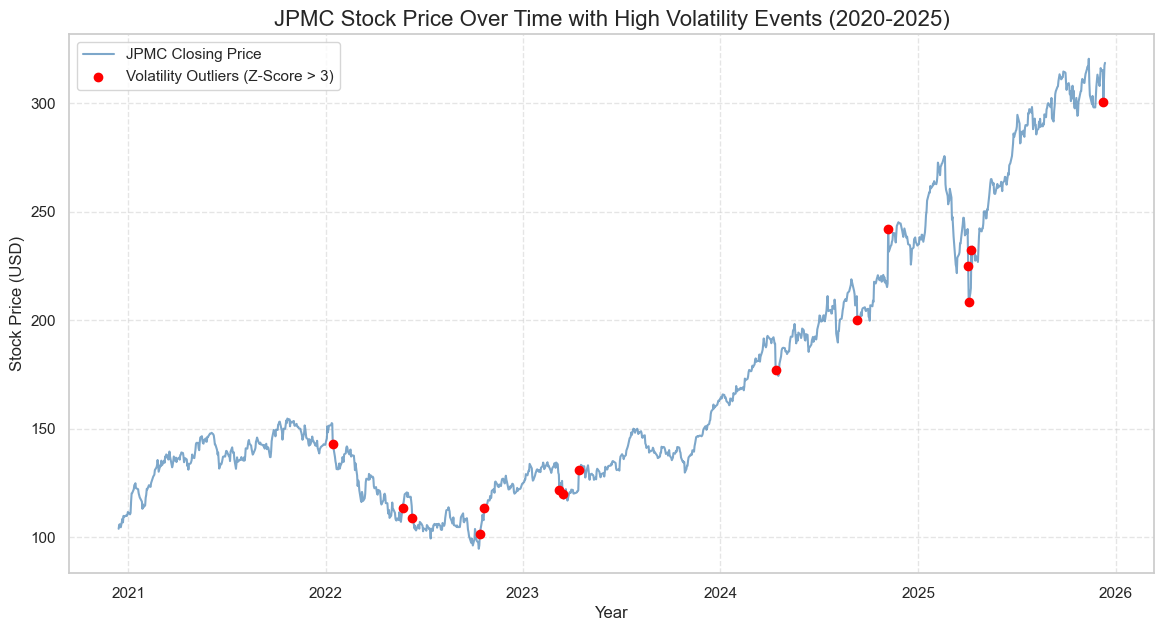

In [9]:
# 1. Set the figure size
plt.figure(figsize=(14, 7))

# 2. Plot the main stock price line
plt.plot(df['Date'], df['Close'], label='JPMC Closing Price', color='steelblue', alpha=0.7)

# 3. Highlight the 15 outliers in red
# We use scatter to put dots exactly on the dates of extreme volatility
plt.scatter(volatility_outliers['Date'], volatility_outliers['Close'], 
            color='red', label='Volatility Outliers (Z-Score > 3)', zorder=5)

# 4. Professional English labels for GitHub
plt.title('JPMC Stock Price Over Time with High Volatility Events (2020-2025)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Stock Price (USD)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('/Users/socratesrgomes/Documents/jpmc-stock-risk-analysis/images/jpmc_risk_timeline.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Market Validation (Volume Analysis)
A price shock is only significant if it is backed by high market participation. 
In this section, we compare the average trading volume of "Normal Days" versus "Outlier Days". 
We also use a scatter plot to analyze the correlation between price magnitude and trading volume.

In [10]:
# 1. Calculate Average Volume for Normal Days vs. Outlier Days
normal_days = df[df['Z_Score'].abs() <= 3]
mean_vol_normal = normal_days['Volume'].mean()
mean_vol_outliers = volatility_outliers['Volume'].mean()

print(f"Average Volume (Normal Days): {mean_vol_normal:,.0f}")
print(f"Average Volume (Outlier Days): {mean_vol_outliers:,.0f}")

# 2. Calculate the "Volume Spike" ratio
increase = mean_vol_outliers / mean_vol_normal
print(f"Outlier days have {increase:.2f}x more volume than normal days.")

Average Volume (Normal Days): 10,996,929
Average Volume (Outlier Days): 26,328,673
Outlier days have 2.39x more volume than normal days.


Average Volume (Normal Days): 10,996,929
Average Volume (Outlier Days): 26,328,673
Outlier days have 2.39x more volume than normal days.


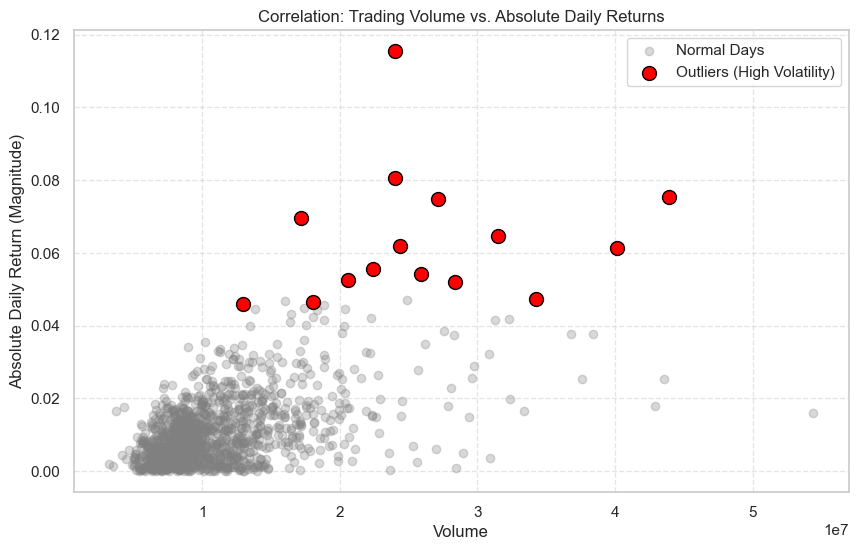

In [11]:
# 1. Calculate Average Volume for Normal Days vs. Outlier Days
# We define "normal" as days where Z-Score is between -3 and 3
normal_days = df[df['Z_Score'].abs() <= 3]

mean_vol_normal = normal_days['Volume'].mean()
mean_vol_outliers = volatility_outliers['Volume'].mean()

print(f"Average Volume (Normal Days): {mean_vol_normal:,.0f}")
print(f"Average Volume (Outlier Days): {mean_vol_outliers:,.0f}")

# 2. Calculate the "Volume Spike" ratio
increase = (mean_vol_outliers / mean_vol_normal)
print(f"Outlier days have {increase:.2f}x more volume than normal days.")

# 3. Scatter Plot: Volume vs. Absolute Daily Return
plt.figure(figsize=(10, 6))
plt.scatter(df['Volume'], df['Daily_Return'].abs(), alpha=0.3, label='Normal Days', color='gray')
plt.scatter(volatility_outliers['Volume'], volatility_outliers['Daily_Return'].abs(), 
            color='red', label='Outliers (High Volatility)', s=100, edgecolors='black')

plt.title('Correlation: Trading Volume vs. Absolute Daily Returns')
plt.xlabel('Volume')
plt.ylabel('Absolute Daily Return (Magnitude)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('/Users/socratesrgomes/Documents/jpmc-stock-risk-analysis/images/jpmc_volume_validation.png', dpi=300, bbox_inches='tight')
plt.show()

## Final Conclusion

This quantitative analysis of JPMorgan Chase (JPMC) stock data from 2020 to 2025 confirms that market risk is highly concentrated in specific, high-impact windows. 

**Key Insights:**
* **Risk Identification**: Using a Z-Score threshold of |Z| > 3, we identified 15 "Black Swan" events that represent the most significant tail-risks for the period.
* **Extreme Event**: The most significant volatility spike occurred on **2024-11-06**, featuring an 11.54% return and a Z-Score of 7.46, statistically marking it as a once-in-a-decade event.
* **Market Validation**: These 15 events were not statistical noise; they were backed by massive market participation, with an average trading volume **2.39x higher** than normal trading days.

**Final Takeaway**: This data-driven approach demonstrates how statistical tools like Z-Score and volume correlation can be effectively used to distinguish between daily market noise and critical systemic shocks, providing a robust foundation for financial risk management strategies.